In [1]:
import pandas as pd
import pickle
from PIL import Image
import numpy as np
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shelve
import math
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pickle5 as pickle
import scipy.io
from scipy.stats import sem
import dataframe_image as dfi
import torchvision.models as models

In [2]:
##dataloader
from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):
    def __init__(self, txt_path, img_dir, transforms = None):
        df = pickle.load(open(txt_path, "rb"))
        df['img'] = df['img'].str.replace("/mmfs1/data/schwarex/neuralNetworks/identity/datasets/img_align_celeba",
                                          img_dir)
        self.txt_path = txt_path
        self.y = df['new_label']
        self.x = df['img']
        self.n_samples = len(df)
        self.transforms = transforms

        self.mu = torch.randn(1503)
        m = torch.distributions.gamma.Gamma(torch.ones(1503), torch.ones(1503) * 20)
        self.sigma = m.sample()

    def __len__(self):
        return self.n_samples


    def __getitem__(self, index):
        image = Image.open(self.x[index]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        label = self.y[index]
        base_reward = torch.randn(1)
        reward = base_reward * self.sigma[label] + self.mu[label]
        data = [image, label, reward]

        return data

## RGB images
transform = transforms.Compose([transforms.CenterCrop(178),  #original image size = (178, 218)
                                transforms.Resize(128),
                                transforms.ToTensor()])       


train_dataset = FaceDataset(txt_path = '/data/zhouabx/celebA/train_SUBSET.pkl',
                            img_dir = '/mmfs1/data/zhouabx/celebA/img_align_celeba/',
                            transforms = transform)

trainloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetEncoder(nn.Module):
    def __init__(self, num_blocks, k):
        super(ResNetEncoder, self).__init__()
        self.in_channels = k
        self.conv1 = nn.Conv2d(3, k, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(k)
        self.layer1 = self._make_layer(k, num_blocks[0], stride = 1)       ## 64
        self.layer2 = self._make_layer(k * 2, num_blocks[1], stride = 2)   ## 64 * 2 = 128
        self.layer3 = self._make_layer(k * 4, num_blocks[2], stride = 2)   ## 64 * 4 = 256
        self.layer4 = self._make_layer(k * 8, num_blocks[3], stride = 2)   ## 64 * 8 = 512

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)       
        out = self.layer4(out)
        return out
   
class ResNet18(nn.Module):
    def __init__(self, k):
        super(ResNet18, self).__init__()
        self.encoder = ResNetEncoder([2, 2, 2, 2], k)
        
        # id classifier 
        self.classifier = nn.Sequential(
            nn.Linear(512, 1503)
        )

    def forward(self, x):
        feature_map = self.encoder(x)
        x = F.adaptive_avg_pool2d(feature_map, (1, 1))
        x = x.view(x.size(0), -1)
        classification = self.classifier(x)
        return x, classification
ResModel = ResNet18(64)

class ResNetVAE(nn.Module):
    def __init__(self, latent_dim = 256):
        super(ResNetVAE, self).__init__()      
        # resnet = models.resnet18(pretrained = False)
        resnet = ResModel.cuda()
        self.encoder = nn.Sequential(*list(resnet.children())[:-1]) # remove the fully connected layers (fc)
        
        # fully connected part
        self.fc_mu = nn.Linear(512 * 16 * 16, latent_dim)     
        self.fc_logvar = nn.Linear(512 * 16 * 16, latent_dim)
        
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 512 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1),   
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(3)
        )

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar) #logVar = log(sigma^2) -> 0.5*logVar.exp = sigma
        eps = torch.randn_like(std)
        # reparametrisation trick
        return mu + std * eps
 
    def forward(self, x):    # encoder -> reparameterization -> decoder
        x = self.encoder(x)
        x = torch.flatten(x, start_dim = 1)      

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        z = self.reparameterize(mu, logvar)       
 
        x = self.decoder_fc(z)
        x = x.view(-1, 512, 16, 16) 
        reconstruction = self.decoder(x)
        return reconstruction, mu, logvar
    
model = ResNetVAE()
model.cuda()

ResNetVAE(
  (encoder): Sequential(
    (0): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 

In [4]:
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, betas = (0.99, 0.999), weight_decay = 1e-5)
reconstruction_criterion = nn.MSELoss()

In [5]:
checkpoint = torch.load('/mmfs1/data/zhouabx/ResNet-18/ResNet_UNSUP/CelebA_train_results/VAE_ResNet_UNSUP_001_500_epoch.ckp',
                        map_location = 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

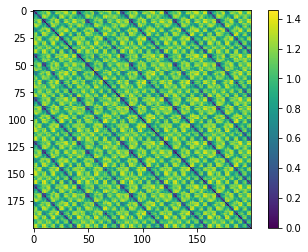

In [6]:
#test on KDEF dataset subset B (note that this is described as dataset A in the paper, and vice versa the dataset that is described as dataset B in the paper is named dataset A in the code)

Dataset_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_B_with_id_expression_direction.pkl', "rb"))   
KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_B = []
model.eval()
with torch.no_grad():
    for idx, row in Dataset_B.iterrows():
        image = Image.open(Dataset_B['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        reconstruction, mu, logVar = model(image[None, :].cuda())
        mu_list_B.append(mu[0, :])      
B_mus = torch.stack((mu_list_B))

#label everything
dictionary_emotion = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
Dataset_B['emotionlabel'] = Dataset_B['expression'].map(dictionary_emotion)

dictionary_view = {'FL' : 0, 'FR' : 1, 'HL' : 2, 'HR' : 3, 'S' : 4}
Dataset_B['viewlabel'] = Dataset_B['direction'].map(dictionary_view)

dictionary_id = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AM08' : 4, 'AM10' : 5, 'AM11' : 6, 'AM25': 7}
Dataset_B['idlabel'] = Dataset_B['id'].map(dictionary_id)

#add mu to the dataset
Dataset_B['mu_B'] = B_mus.cpu().detach()

#order everything
New_Data_B = Dataset_B.sort_values(by = ['emotionlabel', 'viewlabel', 'idlabel'])
#reset the index and save the dataframe in New_Data_B_with_mu
New_Data_B_with_mu = New_Data_B.reset_index(drop = True)

# create array features
array_features_B = [New_Data_B_with_mu['mu_B'][0]]
for i in range(1, New_Data_B_with_mu.shape[0]):
    array_features_B = np.concatenate((array_features_B, [New_Data_B_with_mu['mu_B'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_B, axis = 0)
centered_data = array_features_B - average_vector

# attach centered_feature
New_Data_B_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

# create RDM
l = [None] * 200
for _ in range (len(New_Data_B_with_mu)):
    l [New_Data_B_with_mu.iloc[_]['idlabel'] + 
       8 * New_Data_B_with_mu.iloc[_]['viewlabel'] + 
       8 * 5 * New_Data_B_with_mu.iloc[_]['emotionlabel']] = New_Data_B_with_mu.iloc[_]['centered_feature']

RDM_B = 1 - np.corrcoef(l)

plt.imshow(RDM_B) ## note that this is named RDM A in the paper
plt.colorbar()

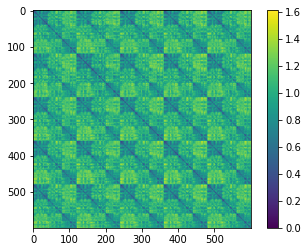

In [7]:
Dataset_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_A_with_id_expression_direction.pkl', "rb"))

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_A = []
model.eval()
with torch.no_grad():
    for idx, row in Dataset_A.iterrows():
        image = Image.open(Dataset_A['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        reconstruction, mu, logVar = model(image[None, :].cuda())
        mu_list_A.append(mu[0, :])
A_mus = torch.stack((mu_list_A))
    
Dataset_A['mu_A'] = A_mus.cpu().detach()
Dataset_A_with_mu = Dataset_A  

#average the L and R         
Dataset_A_with_mu["new_direction"] = np.where((Dataset_A_with_mu["direction"].values == "HR") | (Dataset_A_with_mu["direction"] == "HL"), 
         "H", 
         np.where((Dataset_A_with_mu["direction"].values == "FR") | (Dataset_A_with_mu["direction"] == "FL"), 
         "F", 
         Dataset_A_with_mu["direction"].values))        
         

group_index = Dataset_A_with_mu.agg('{0[expression]} and {0[new_direction]} and {0[id]}'.format, axis = 1)

ids = np.unique(group_index)
g_mean = np.array([np.mean(A_mus.cpu().detach().numpy()[group_index == i, 0:], axis = 0) for i in ids])

df_LR_ave = pd.DataFrame(data = np.array(list(map(lambda x : np.str.split(x, sep = " and "), ids))))
df_LR_ave.columns = ["expression", "direction", "id"]
df_LR_ave['mu_A'] = g_mean.tolist()
                
#label everything
dictionary_emotion_A = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
df_LR_ave['emotionlabel_A'] = df_LR_ave['expression'].map(dictionary_emotion_A)

dictionary_view_A = {'F' : 0, 'H' : 1, 'S' : 2}
df_LR_ave['viewlabel_A'] = df_LR_ave['direction'].map(dictionary_view_A)

dictionary_id_A = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AF06' : 4, 'AF07' : 5, 'AF09' : 6, 'AF13' : 7, 'AF14' : 8, 'AF16' : 9,
 'AF20' : 10, 'AF21' : 11, 'AF22' : 12, 'AF24' : 13, 'AF25': 14, 'AF28' : 15, 'AF29' : 16, 'AF30' : 17, 'AF32' : 18, 
 'AF33' : 19, 'AM01' : 20, 'AM05' : 21, 'AM06' : 22, 'AM08' : 23, 'AM09' : 24, 'AM10' : 25, 'AM11' : 26, 'AM13' : 27,
 'AM14' : 28, 'AM15' : 29, 'AM16' : 30, 'AM22' : 31, 'AM23' : 32, 'AM24' : 33, 'AM25' : 34, 'AM28' : 35, 'AM29' : 36,
 'AM30' : 37, 'AM31' : 38, 'AM35' : 39}
df_LR_ave['idlabel_A'] = df_LR_ave['id'].map(dictionary_id_A)

#order everything
New_Data_A = df_LR_ave.sort_values(by = ['emotionlabel_A', 'viewlabel_A', 'idlabel_A'])
#reset the index and save the dataframe in New_Data_A_with_mu
New_Data_A_with_mu = New_Data_A.reset_index(drop = True)  

# create array features
array_features_A = [New_Data_A_with_mu['mu_A'][0]]
for i in range(1, New_Data_A_with_mu.shape[0]):
    array_features_A = np.concatenate((array_features_A, [New_Data_A_with_mu['mu_A'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_A, axis = 0)
centered_data = array_features_A - average_vector

# attach centered_feature
New_Data_A_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

l_A = [None] * 600
for _ in range (len(New_Data_A_with_mu)):
    l_A [New_Data_A_with_mu.iloc[_]['idlabel_A'] + 
         40 * New_Data_A_with_mu.iloc[_]['viewlabel_A'] + 
         40 * 3 * New_Data_A_with_mu.iloc[_]['emotionlabel_A']] = New_Data_A_with_mu.iloc[_]['centered_feature']      

RDM_A = 1 - np.corrcoef(l_A)      

plt.imshow(RDM_A) ## note that this is named RDM B in the paper
plt.colorbar()

In [8]:
#save RDM value
path = "/data/zhouabx/ResNet-18/ResNet_UNSUP/KDEF_test_results_AB/"
with open(path + 'RDM_value_A.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_A, pickle_out)
        
with open(path + 'RDM_value_B.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_B, pickle_out)

In [2]:
# open RDMs for KDEF A & B
Res_UNSUP_RDM_value_A = pickle.load(open('/mmfs1/data/zhouabx/ResNet-18/ResNet_UNSUP/KDEF_test_results_AB/RDM_value_A.pkl',"rb"))
v_Res_UNSUP_RDM_value_A = Res_UNSUP_RDM_value_A[np.triu_indices(Res_UNSUP_RDM_value_A.shape[0], 1)]

Res_UNSUP_RDM_value_B = pickle.load(open('/mmfs1/data/zhouabx/ResNet-18/ResNet_UNSUP/KDEF_test_results_AB/RDM_value_B.pkl',"rb"))
v_Res_UNSUP_RDM_value_B = Res_UNSUP_RDM_value_B[np.triu_indices(Res_UNSUP_RDM_value_B.shape[0], 1)]

In [3]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p16/'
vA_p16_rdms = []
v_vA_p16_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p16_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p16_rdms)):
    vector = vA_p16_rdms[i][np.triu_indices(vA_p16_rdms[i].shape[0], 1)]
    v_vA_p16_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p16 = []
for i in range (len(v_vA_p16_rdms)):   
    kendalltau_UNSUP_and_vA_p16.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p16_rdms[i]))
    
corr, _ = kendalltau_UNSUP_and_vA_p16[0]
print('subset A UNSUP and p16_e90_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p16[1]
print('subset A UNSUP and p16_e90_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p16[2]
print('subset A UNSUP and p16_e90_wind6 kendalltau: %.5f' % corr)

subset A UNSUP and p16_e90_wind4 kendalltau: 0.03131
subset A UNSUP and p16_e90_wind5 kendalltau: 0.02357
subset A UNSUP and p16_e90_wind6 kendalltau: 0.00890


In [4]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p23/'
vA_p23_rdms = []
v_vA_p23_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p23_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p23_rdms)):
    vector = vA_p23_rdms[i][np.triu_indices(vA_p23_rdms[i].shape[0], 1)]
    v_vA_p23_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p23 = []
for i in range (len(v_vA_p23_rdms)):   
    kendalltau_UNSUP_and_vA_p23.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p23_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vA_p23[0]
print('subset A UNSUP and p23_wind4 kendalltau: 0')
corr, _ = kendalltau_UNSUP_and_vA_p23[1]
print('subset A UNSUP and p23_wind5 kendalltau: 0')
corr, _ = kendalltau_UNSUP_and_vA_p23[2]
print('subset A UNSUP and p23_wind6 kendalltau: 0')

subset A UNSUP and p23_wind4 kendalltau: 0
subset A UNSUP and p23_wind5 kendalltau: 0
subset A UNSUP and p23_wind6 kendalltau: 0


In [5]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p27/'
vA_p27_rdms = []
v_vA_p27_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p27_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p27_rdms)):
    vector = vA_p27_rdms[i][np.triu_indices(vA_p27_rdms[i].shape[0], 1)]
    v_vA_p27_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p27 = []
for i in range (len(v_vA_p27_rdms)):   
    kendalltau_UNSUP_and_vA_p27.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p27_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vA_p27[0]
print('subset A UNSUP and p27_e100_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[1]
print('subset A UNSUP and p27_e100_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[2]
print('subset A UNSUP and p27_e100_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[3]
print('subset A UNSUP and p27_e53_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[4]
print('subset A UNSUP and p27_e53_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[5]
print('subset A UNSUP and p27_e53_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[6]
print('subset A UNSUP and p27_e60_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[7]
print('subset A UNSUP and p27_e60_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[8]
print('subset A UNSUP and p27_e60_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[9]
print('subset A UNSUP and p27_e61_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[10]
print('subset A UNSUP and p27_e61_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[11]
print('subset A UNSUP and p27_e61_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[12]
print('subset A UNSUP and p27_e62_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[13]
print('subset A UNSUP and p27_e62_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p27[14]
print('subset A UNSUP and p27_e62_wind6 kendalltau: %.5f' % corr)

subset A UNSUP and p27_e100_wind4 kendalltau: 0.04209
subset A UNSUP and p27_e100_wind5 kendalltau: 0.02510
subset A UNSUP and p27_e100_wind6 kendalltau: 0.01003
subset A UNSUP and p27_e53_wind4 kendalltau: 0.04936
subset A UNSUP and p27_e53_wind5 kendalltau: 0.06445
subset A UNSUP and p27_e53_wind6 kendalltau: 0.03707
subset A UNSUP and p27_e60_wind4 kendalltau: 0.02082
subset A UNSUP and p27_e60_wind5 kendalltau: 0.02916
subset A UNSUP and p27_e60_wind6 kendalltau: 0.00572
subset A UNSUP and p27_e61_wind4 kendalltau: 0.01069
subset A UNSUP and p27_e61_wind5 kendalltau: 0.03836
subset A UNSUP and p27_e61_wind6 kendalltau: 0.01949
subset A UNSUP and p27_e62_wind4 kendalltau: 0.04045
subset A UNSUP and p27_e62_wind5 kendalltau: 0.04325
subset A UNSUP and p27_e62_wind6 kendalltau: 0.02935


In [6]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p28/'
vA_p28_rdms = []
v_vA_p28_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p28_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p28_rdms)):
    vector = vA_p28_rdms[i][np.triu_indices(vA_p28_rdms[i].shape[0], 1)]
    v_vA_p28_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p28 = []
for i in range (len(v_vA_p28_rdms)):   
    kendalltau_UNSUP_and_vA_p28.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p28_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vA_p28[0]
print('subset A UNSUP and p28_e85_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p28[1]
print('subset A UNSUP and p28_e85_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p28[2]
print('subset A UNSUP and p28_e85_wind6 kendalltau: %.5f' % corr)

subset A UNSUP and p28_e85_wind4 kendalltau: 0.03766
subset A UNSUP and p28_e85_wind5 kendalltau: 0.00952
subset A UNSUP and p28_e85_wind6 kendalltau: 0.00434


In [7]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p30/'
vA_p30_rdms = []
v_vA_p30_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p30_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p30_rdms)):
    vector = vA_p30_rdms[i][np.triu_indices(vA_p30_rdms[i].shape[0], 1)]
    v_vA_p30_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p30 = []
for i in range (len(v_vA_p30_rdms)):   
    kendalltau_UNSUP_and_vA_p30.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p30_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vA_p30[0]
print('subset A UNSUP and p30_e8_wind4 kendalltau: 0')
corr, _ = kendalltau_UNSUP_and_vA_p30[1]
print('subset A UNSUP and p30_e8_wind5 kendalltau: 0')
corr, _ = kendalltau_UNSUP_and_vA_p30[2]
print('subset A UNSUP and p30_e8_wind6 kendalltau: %.5f' % corr)

subset A UNSUP and p30_e8_wind4 kendalltau: 0
subset A UNSUP and p30_e8_wind5 kendalltau: 0
subset A UNSUP and p30_e8_wind6 kendalltau: 0.00063


In [8]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p34/'
vA_p34_rdms = []
v_vA_p34_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p34_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p34_rdms)):
    vector = vA_p34_rdms[i][np.triu_indices(vA_p34_rdms[i].shape[0], 1)]
    v_vA_p34_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p34 = []
for i in range (len(v_vA_p34_rdms)):   
    kendalltau_UNSUP_and_vA_p34.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p34_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vA_p34[0]
print('subset A UNSUP and p34_e23_wind4 kendalltau: 0')
corr, _ = kendalltau_UNSUP_and_vA_p34[1]
print('subset A UNSUP and p34_e23_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[2]
print('subset A UNSUP and p34_e23_wind6 kendalltau: 0')
corr, _ = kendalltau_UNSUP_and_vA_p34[3]
print('subset A UNSUP and p34_e42_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[4]
print('subset A UNSUP and p34_e42_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[5]
print('subset A UNSUP and p34_e42_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[6]
print('subset A UNSUP and p34_e44_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[7]
print('subset A UNSUP and p34_e44_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[8]
print('subset A UNSUP and p34_e44_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[9]
print('subset A UNSUP and p43_e43_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[10]
print('subset A UNSUP and p43_e43_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p34[11]
print('subset A UNSUP and p43_e43_wind6 kendalltau: %.5f' % corr)

subset A UNSUP and p34_e23_wind4 kendalltau: 0
subset A UNSUP and p34_e23_wind5 kendalltau: 0.00157
subset A UNSUP and p34_e23_wind6 kendalltau: 0
subset A UNSUP and p34_e42_wind4 kendalltau: 0.01809
subset A UNSUP and p34_e42_wind5 kendalltau: 0.00461
subset A UNSUP and p34_e42_wind6 kendalltau: 0.00335
subset A UNSUP and p34_e44_wind4 kendalltau: 0.01984
subset A UNSUP and p34_e44_wind5 kendalltau: 0.01755
subset A UNSUP and p34_e44_wind6 kendalltau: 0.00384
subset A UNSUP and p43_e43_wind4 kendalltau: 0.06344
subset A UNSUP and p43_e43_wind5 kendalltau: 0.03111
subset A UNSUP and p43_e43_wind6 kendalltau: 0.00587


In [9]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p36/'
vA_p36_rdms = []
v_vA_p36_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p36_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p36_rdms)):
    vector = vA_p36_rdms[i][np.triu_indices(vA_p36_rdms[i].shape[0], 1)]
    v_vA_p36_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p36 = []
for i in range (len(v_vA_p36_rdms)):   
    kendalltau_UNSUP_and_vA_p36.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p36_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vA_p36[0]
print('subset A UNSUP and p36_e64_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[1]
print('subset A UNSUP and p36_e64_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[2]
print('subset A UNSUP and p36_e64_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[3]
print('subset A UNSUP and p36_e69_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[4]
print('subset A UNSUP and p36_e69_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[5]
print('subset A UNSUP and p36_e69_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[6]
print('subset A UNSUP and p36_e70_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[7]
print('subset A UNSUP and p36_e70_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p36[8]
print('subset A UNSUP and p36_e70_wind6 kendalltau: %.5f' % corr)

subset A UNSUP and p36_e64_wind4 kendalltau: 0.09297
subset A UNSUP and p36_e64_wind5 kendalltau: 0.06632
subset A UNSUP and p36_e64_wind6 kendalltau: 0.04224
subset A UNSUP and p36_e69_wind4 kendalltau: 0.00250
subset A UNSUP and p36_e69_wind5 kendalltau: 0.00352
subset A UNSUP and p36_e69_wind6 kendalltau: 0.00750
subset A UNSUP and p36_e70_wind4 kendalltau: 0.00210
subset A UNSUP and p36_e70_wind5 kendalltau: 0.00352
subset A UNSUP and p36_e70_wind6 kendalltau: 0.00228


In [10]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p39/'
vA_p39_rdms = []
v_vA_p39_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p39_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p39_rdms)):
    vector = vA_p39_rdms[i][np.triu_indices(vA_p39_rdms[i].shape[0], 1)]
    v_vA_p39_rdms.append(vector)
    
kendalltau_UNSUP_and_vA_p39 = []
for i in range (len(v_vA_p39_rdms)):   
    kendalltau_UNSUP_and_vA_p39.append(stats.kendalltau(v_Res_UNSUP_RDM_value_A, v_vA_p39_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vA_p39[0]
print('subset A UNSUP and p39_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vA_p39[1]
print('subset A UNSUP and p39_wind5 kendalltau: 0')
corr, _ = kendalltau_UNSUP_and_vA_p39[2]
print('subset A UNSUP and p39_wind6 kendalltau: 0')

subset A UNSUP and p39_wind4 kendalltau: 0.00061
subset A UNSUP and p39_wind5 kendalltau: 0
subset A UNSUP and p39_wind6 kendalltau: 0


In [11]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/p41/'
vB_p41_rdms = []
v_vB_p41_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p41_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p41_rdms)):
    vector = vB_p41_rdms[i][np.triu_indices(vB_p41_rdms[i].shape[0], 1)]
    v_vB_p41_rdms.append(vector)
    
kendalltau_UNSUP_and_vB_p41 = []
for i in range (len(v_vB_p41_rdms)):   
    kendalltau_UNSUP_and_vB_p41.append(stats.kendalltau(v_Res_UNSUP_RDM_value_B, v_vB_p41_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vB_p41[1]
print('subset B UNSUP and p41_e10_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[2]
print('subset B UNSUP and p41_e10_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[3]
print('subset B UNSUP and p41_e10_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[7]
print('subset B UNSUP and p41_e11_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[8]
print('subset B UNSUP and p41_e11_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[9]
print('subset B UNSUP and p41_e11_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[13]
print('subset B UNSUP and p41_e12_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[14]
print('subset B UNSUP and p41_e12_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[15]
print('subset B UNSUP and p41_e12_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[19]
print('subset B UNSUP and p41_e2_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[20]
print('subset B UNSUP and p41_e2_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[21]
print('subset B UNSUP and p41_e2_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[25]
print('subset B UNSUP and p41_e24_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[26]
print('subset B UNSUP and p41_e24_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[27]
print('subset B UNSUP and p41_e24_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[31]
print('subset B UNSUP and p41_e9_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[32]
print('subset B UNSUP and p41_e9_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p41[33]
print('subset B UNSUP and p41_e9_wind6 kendalltau: %.5f' % corr)

subset B UNSUP and p41_e10_wind4 kendalltau: 0.13380
subset B UNSUP and p41_e10_wind5 kendalltau: 0.11279
subset B UNSUP and p41_e10_wind6 kendalltau: 0.02702
subset B UNSUP and p41_e11_wind4 kendalltau: 0.07808
subset B UNSUP and p41_e11_wind5 kendalltau: 0.06191
subset B UNSUP and p41_e11_wind6 kendalltau: 0.01127
subset B UNSUP and p41_e12_wind4 kendalltau: 0.03825
subset B UNSUP and p41_e12_wind5 kendalltau: 0.02723
subset B UNSUP and p41_e12_wind6 kendalltau: 0.01606
subset B UNSUP and p41_e2_wind4 kendalltau: 0.08823
subset B UNSUP and p41_e2_wind5 kendalltau: 0.04471
subset B UNSUP and p41_e2_wind6 kendalltau: 0.00056
subset B UNSUP and p41_e24_wind4 kendalltau: 0.06374
subset B UNSUP and p41_e24_wind5 kendalltau: 0.03520
subset B UNSUP and p41_e24_wind6 kendalltau: 0.00630
subset B UNSUP and p41_e9_wind4 kendalltau: 0.11414
subset B UNSUP and p41_e9_wind5 kendalltau: 0.07774
subset B UNSUP and p41_e9_wind6 kendalltau: 0.00772


In [12]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/fusiform_reliable/p47/'
vB_p47_rdms = []
v_vB_p47_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p47_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p47_rdms)):
    vector = vB_p47_rdms[i][np.triu_indices(vB_p47_rdms[i].shape[0], 1)]
    v_vB_p47_rdms.append(vector)

kendalltau_UNSUP_and_vB_p47 = []
for i in range (len(v_vB_p47_rdms)):   
    kendalltau_UNSUP_and_vB_p47.append(stats.kendalltau(v_Res_UNSUP_RDM_value_B, v_vB_p47_rdms[i]))

corr, _ = kendalltau_UNSUP_and_vB_p47[1]
print('subset B UNSUP and p47_e34_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p47[2]
print('subset B UNSUP and p47_e34_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_and_vB_p47[3]
print('subset B UNSUP and p47_e34_wind6 kendalltau: %.5f' % corr)

subset B UNSUP and p47_e34_wind4 kendalltau: 0.10367
subset B UNSUP and p47_e34_wind5 kendalltau: 0.05854
subset B UNSUP and p47_e34_wind6 kendalltau: 0.00878


In [13]:
# path = "/data/zhouabx/ResNet-18/ResNet_UNSUP/KDEF_test_results_AB/kendalltaus/"

UNSUP_tau_wind4 = np.array([kendalltau_UNSUP_and_vA_p16[0][0],
                            0,
                            kendalltau_UNSUP_and_vA_p27[0][0],
                            kendalltau_UNSUP_and_vA_p27[3][0],
                            kendalltau_UNSUP_and_vA_p27[6][0],
                            kendalltau_UNSUP_and_vA_p27[9][0],
                            kendalltau_UNSUP_and_vA_p27[12][0],
                            kendalltau_UNSUP_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_UNSUP_and_vA_p34[3][0],
                            kendalltau_UNSUP_and_vA_p34[6][0],
                            kendalltau_UNSUP_and_vA_p34[9][0],
                            kendalltau_UNSUP_and_vA_p36[0][0],
                            kendalltau_UNSUP_and_vA_p36[3][0],
                            kendalltau_UNSUP_and_vA_p36[6][0],
                            kendalltau_UNSUP_and_vA_p39[0][0],
                            kendalltau_UNSUP_and_vB_p41[1][0],
                            kendalltau_UNSUP_and_vB_p41[7][0],
                            kendalltau_UNSUP_and_vB_p41[13][0],
                            kendalltau_UNSUP_and_vB_p41[19][0],
                            kendalltau_UNSUP_and_vB_p41[25][0],
                            kendalltau_UNSUP_and_vB_p41[31][0],
                            kendalltau_UNSUP_and_vB_p47[1][0]])

UNSUP_tau_wind4_mean = np.mean(UNSUP_tau_wind4)
UNSUP_tau_wind4_sem = sem(UNSUP_tau_wind4)

# with open(path + 'ResNet_UNSUP_tau_wind4.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind4, pickle_out)      
# with open(path + 'ResNet_UNSUP_tau_wind4_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind4_mean, pickle_out) 
# with open(path + 'ResNet_UNSUP_tau_wind4_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind4_sem, pickle_out) 


UNSUP_tau_wind5 = np.array([kendalltau_UNSUP_and_vA_p16[1][0],
                            0,
                            kendalltau_UNSUP_and_vA_p27[1][0],
                            kendalltau_UNSUP_and_vA_p27[4][0],
                            kendalltau_UNSUP_and_vA_p27[7][0],
                            kendalltau_UNSUP_and_vA_p27[10][0],
                            kendalltau_UNSUP_and_vA_p27[13][0],
                            kendalltau_UNSUP_and_vA_p28[1][0],
                            0,
                            kendalltau_UNSUP_and_vA_p34[1][0],
                            kendalltau_UNSUP_and_vA_p34[4][0],
                            kendalltau_UNSUP_and_vA_p34[7][0],
                            kendalltau_UNSUP_and_vA_p34[10][0],
                            kendalltau_UNSUP_and_vA_p36[1][0],
                            kendalltau_UNSUP_and_vA_p36[4][0],
                            kendalltau_UNSUP_and_vA_p36[7][0],
                            0,
                            kendalltau_UNSUP_and_vB_p41[2][0],
                            kendalltau_UNSUP_and_vB_p41[8][0],
                            kendalltau_UNSUP_and_vB_p41[14][0],
                            kendalltau_UNSUP_and_vB_p41[20][0],
                            kendalltau_UNSUP_and_vB_p41[26][0],
                            kendalltau_UNSUP_and_vB_p41[32][0],
                            kendalltau_UNSUP_and_vB_p47[2][0]])

UNSUP_tau_wind5_mean = np.mean(UNSUP_tau_wind5)
UNSUP_tau_wind5_sem = sem(UNSUP_tau_wind5)

# with open(path + 'ResNet_UNSUP_tau_wind5.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind5, pickle_out)      
# with open(path + 'ResNet_UNSUP_tau_wind5_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind5_mean, pickle_out) 
# with open(path + 'ResNet_UNSUP_tau_wind5_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind5_sem, pickle_out) 


UNSUP_tau_wind6 = np.array([kendalltau_UNSUP_and_vA_p16[2][0],
                            0,
                            kendalltau_UNSUP_and_vA_p27[2][0],
                            kendalltau_UNSUP_and_vA_p27[5][0],
                            kendalltau_UNSUP_and_vA_p27[8][0],
                            kendalltau_UNSUP_and_vA_p27[11][0],
                            kendalltau_UNSUP_and_vA_p27[14][0],
                            kendalltau_UNSUP_and_vA_p28[2][0],
                            kendalltau_UNSUP_and_vA_p30[2][0],
                            0,
                            kendalltau_UNSUP_and_vA_p34[5][0],
                            kendalltau_UNSUP_and_vA_p34[8][0],
                            kendalltau_UNSUP_and_vA_p34[11][0],
                            kendalltau_UNSUP_and_vA_p36[2][0],
                            kendalltau_UNSUP_and_vA_p36[5][0],
                            kendalltau_UNSUP_and_vA_p36[8][0],
                            0,
                            kendalltau_UNSUP_and_vB_p41[3][0],
                            kendalltau_UNSUP_and_vB_p41[9][0],
                            kendalltau_UNSUP_and_vB_p41[15][0],
                            kendalltau_UNSUP_and_vB_p41[21][0],
                            kendalltau_UNSUP_and_vB_p41[27][0],
                            kendalltau_UNSUP_and_vB_p41[33][0],
                            kendalltau_UNSUP_and_vB_p47[3][0]])

UNSUP_tau_wind6_mean = np.mean(UNSUP_tau_wind6)
UNSUP_tau_wind6_sem = sem(UNSUP_tau_wind6)

# with open(path + 'ResNet_UNSUP_tau_wind6.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind6, pickle_out)      
# with open(path + 'ResNet_UNSUP_tau_wind6_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind6_mean, pickle_out) 
# with open(path + 'ResNet_UNSUP_tau_wind6_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(UNSUP_tau_wind6_sem, pickle_out) 

In [15]:
d_ResUNSUP_tau_wind4 = {'value': [kendalltau_UNSUP_and_vA_p16[0][0],
                            0,
                            kendalltau_UNSUP_and_vA_p27[0][0],
                            kendalltau_UNSUP_and_vA_p27[3][0],
                            kendalltau_UNSUP_and_vA_p27[6][0],
                            kendalltau_UNSUP_and_vA_p27[9][0],
                            kendalltau_UNSUP_and_vA_p27[12][0],
                            kendalltau_UNSUP_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_UNSUP_and_vA_p34[3][0],
                            kendalltau_UNSUP_and_vA_p34[6][0],
                            kendalltau_UNSUP_and_vA_p34[9][0],
                            kendalltau_UNSUP_and_vA_p36[0][0],
                            kendalltau_UNSUP_and_vA_p36[3][0],
                            kendalltau_UNSUP_and_vA_p36[6][0],
                            kendalltau_UNSUP_and_vA_p39[0][0],
                            kendalltau_UNSUP_and_vB_p41[1][0],
                            kendalltau_UNSUP_and_vB_p41[7][0],
                            kendalltau_UNSUP_and_vB_p41[13][0],
                            kendalltau_UNSUP_and_vB_p41[19][0],
                            kendalltau_UNSUP_and_vB_p41[25][0],
                            kendalltau_UNSUP_and_vB_p41[31][0],
                            kendalltau_UNSUP_and_vB_p47[1][0]], 
     'window': ['window4'] * len(UNSUP_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['ResNet UNSUP'] * len(UNSUP_tau_wind4)}
ResUNSUP_tau_wind4 = pd.DataFrame(data = d_ResUNSUP_tau_wind4)

d_ResUNSUP_tau_wind5 = {'value': [kendalltau_UNSUP_and_vA_p16[1][0],
                            0,
                            kendalltau_UNSUP_and_vA_p27[1][0],
                            kendalltau_UNSUP_and_vA_p27[4][0],
                            kendalltau_UNSUP_and_vA_p27[7][0],
                            kendalltau_UNSUP_and_vA_p27[10][0],
                            kendalltau_UNSUP_and_vA_p27[13][0],
                            kendalltau_UNSUP_and_vA_p28[1][0],
                            0,
                            kendalltau_UNSUP_and_vA_p34[1][0],
                            kendalltau_UNSUP_and_vA_p34[4][0],
                            kendalltau_UNSUP_and_vA_p34[7][0],
                            kendalltau_UNSUP_and_vA_p34[10][0],
                            kendalltau_UNSUP_and_vA_p36[1][0],
                            kendalltau_UNSUP_and_vA_p36[4][0],
                            kendalltau_UNSUP_and_vA_p36[7][0],
                            0,
                            kendalltau_UNSUP_and_vB_p41[2][0],
                            kendalltau_UNSUP_and_vB_p41[8][0],
                            kendalltau_UNSUP_and_vB_p41[14][0],
                            kendalltau_UNSUP_and_vB_p41[20][0],
                            kendalltau_UNSUP_and_vB_p41[26][0],
                            kendalltau_UNSUP_and_vB_p41[32][0],
                            kendalltau_UNSUP_and_vB_p47[2][0]], 
     'window': ['window5'] * len(UNSUP_tau_wind5), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['ResNet UNSUP'] * len(UNSUP_tau_wind5)}
ResUNSUP_tau_wind5 = pd.DataFrame(data = d_ResUNSUP_tau_wind5)

d_ResUNSUP_tau_wind6 = {'value': [kendalltau_UNSUP_and_vA_p16[2][0],
                            0,
                            kendalltau_UNSUP_and_vA_p27[2][0],
                            kendalltau_UNSUP_and_vA_p27[5][0],
                            kendalltau_UNSUP_and_vA_p27[8][0],
                            kendalltau_UNSUP_and_vA_p27[11][0],
                            kendalltau_UNSUP_and_vA_p27[14][0],
                            kendalltau_UNSUP_and_vA_p28[2][0],
                            kendalltau_UNSUP_and_vA_p30[2][0],
                            0,
                            kendalltau_UNSUP_and_vA_p34[5][0],
                            kendalltau_UNSUP_and_vA_p34[8][0],
                            kendalltau_UNSUP_and_vA_p34[11][0],
                            kendalltau_UNSUP_and_vA_p36[2][0],
                            kendalltau_UNSUP_and_vA_p36[5][0],
                            kendalltau_UNSUP_and_vA_p36[8][0],
                            0,
                            kendalltau_UNSUP_and_vB_p41[3][0],
                            kendalltau_UNSUP_and_vB_p41[9][0],
                            kendalltau_UNSUP_and_vB_p41[15][0],
                            kendalltau_UNSUP_and_vB_p41[21][0],
                            kendalltau_UNSUP_and_vB_p41[27][0],
                            kendalltau_UNSUP_and_vB_p41[33][0],
                            kendalltau_UNSUP_and_vB_p47[3][0]], 
     'window': ['window6'] * len(UNSUP_tau_wind6), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['ResNet UNSUP'] * len(UNSUP_tau_wind6)}
ResUNSUP_tau_wind6 = pd.DataFrame(data = d_ResUNSUP_tau_wind6)

ResUNSUP = pd.concat([ResUNSUP_tau_wind4, ResUNSUP_tau_wind5, ResUNSUP_tau_wind6])
ResUNSUP

,value,window,subject,model
0,0.031306,window4,16,ResNet UNSUP
1,0.000000,window4,23,ResNet UNSUP
2,0.042092,window4,27,ResNet UNSUP
3,0.049356,window4,27,ResNet UNSUP
4,0.020818,window4,27,ResNet UNSUP
...,...,...,...,...
19,0.016063,window6,41,ResNet UNSUP
20,0.000559,window6,41,ResNet UNSUP
21,0.006302,window6,41,ResNet UNSUP
22,0.007722,window6,41,ResNet UNSUP


In [16]:
path = "/data/zhouabx/ResNet-18/ResNet_UNSUP/ResUNSUP_ttest_df/"
with open(path + 'ResUNSUP.pkl', 'wb') as pickle_out:
     pickle.dump(ResUNSUP, pickle_out)      